In [1]:
# Make sure we can import EMQST_lib from parent directory
import sys
from pathlib import Path

# Go two levels up from current working directory
PROJECT_ROOT = Path.cwd().resolve().parents[1]   # <- one up (your earlier case)


if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Using project root:", PROJECT_ROOT)

# Notebook is in project-root/Multiplexed_qubit_readout_results/
# -> project root is the parent of the current working dir
PROJECT_ROOT = Path.cwd().resolve().parent


if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


import numpy as np 
from datetime import datetime
import os
import uuid
import glob
from EMQST_lib import adaptive_functions as ad
from EMQST_lib.qst import QST  
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import support_functions as sf
from EMQST_lib.povm import POVM
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%load_ext autoreload
%autoreload 2

Using project root: /workspaces/REMQST


In [2]:
n_shots_total = 10**3
n_qubits = 2
n_shots = n_shots_total//3**n_qubits # In the qst code it is assumed that each single qubit measurement is a Pauli-basis, hence 3^n_qubits total measurement settings.
n_averages = 1
adaptive_burnin = 200
n_cores = 6
print(f'Starting adaptive QST with {n_shots_total} shots, {n_qubits} qubits, {n_averages} averages, and adaptive burnin of {adaptive_burnin}.')

true_states = np.array([sf.generate_random_pure_state(n_qubits) for _ in range(n_averages)])
povm = POVM.generate_Pauli_POVM(n_qubits)
decompiled_array = np.array([povm[i].get_POVM() for i in range(len(povm))])
pauli_6_array = 1/3**(n_qubits)*np.array(decompiled_array.reshape(-1,decompiled_array.shape[-2],decompiled_array.shape[-1]))
test_POVM = POVM(pauli_6_array)
qst_adaptive = QST(povm, true_states, n_shots, n_qubits, False,{}, n_cores=n_cores)


print(f'Total shots for the whole run: {n_shots_total * n_averages}')

n_steps = 2
noise_step = 0.1
infidelity_container_nonadaptive = []
infidelity_container_adaptive = []
qst_array = []
noise_strengths = []
setting_array = []

start_time = datetime.now()


for i in range(n_steps):
    # Adaptive QST
    print(f'Starting adaptive QST run {i}')
    depolarizing_strength = i * noise_step
    qst_adaptive = QST(povm, true_states, n_shots, n_qubits, False,{}, n_cores=n_cores)
    qst_adaptive.perform_adaptive_BME(depolarizing_strength = depolarizing_strength,
                            adaptive_burnin_steps = adaptive_burnin)

    noise_strengths.append(depolarizing_strength)
    qst_array.append(qst_adaptive)
    infidelity_container_adaptive.append(qst_adaptive.get_infidelity())
    print(f'Adaptive QST run {i} took {datetime.now()-start_time}')
    # For non_adaptive QST we need to supply it with the noisy POVM separatly. 
    depolarized_pauli_6_array = np.array([sf.depolarizing_channel(np.copy(element), depolarizing_strength) for element in pauli_6_array])
    noisy_povm = POVM(depolarized_pauli_6_array)
    # # Note that we use n_shots*3**n_qubits here, since nonadaptive QST does not split the shots between different measurement settings. 
    # # We also multiply rather than use n_shots total since there could be rounding difference between the adaptive and non-daptive QST. 
    qst_nonadaptive = QST([noisy_povm], true_states, n_shots*3**n_qubits, n_qubits, False,{}, n_cores=n_cores) # They are initalized the same
    qst_nonadaptive.generate_data()
    qst_nonadaptive.perform_BME()
    infidelity_container_nonadaptive.append(qst_nonadaptive.get_infidelity())
    
    
    settings = {
        'n_shots': n_shots,
        'n_qubits': n_qubits,
        'n_averages': n_averages,
        'adaptive_burnin': adaptive_burnin,
        'noise_strengths': noise_strengths,
        'true_states': true_states,
        'reconstructed_states_adaptive': qst_adaptive.get_rho_estm(),
        'reconstructed_states_nonadaptive': qst_nonadaptive.get_rho_estm(),
    }
    setting_array.append(settings)



container_dict = {
    'adaptive_infidelity_container': infidelity_container_adaptive,
    'nonadaptive_infidelity_container': infidelity_container_nonadaptive
}


Starting adaptive QST with 1000 shots, 2 qubits, 1 averages, and adaptive burnin of 200.
Total shots for the whole run: 1000
Starting adaptive QST run 0


KeyboardInterrupt: 

(2, 1, 999)
(2, 1, 999)
[[0.0, 0.1], [0.0, 0.1]]


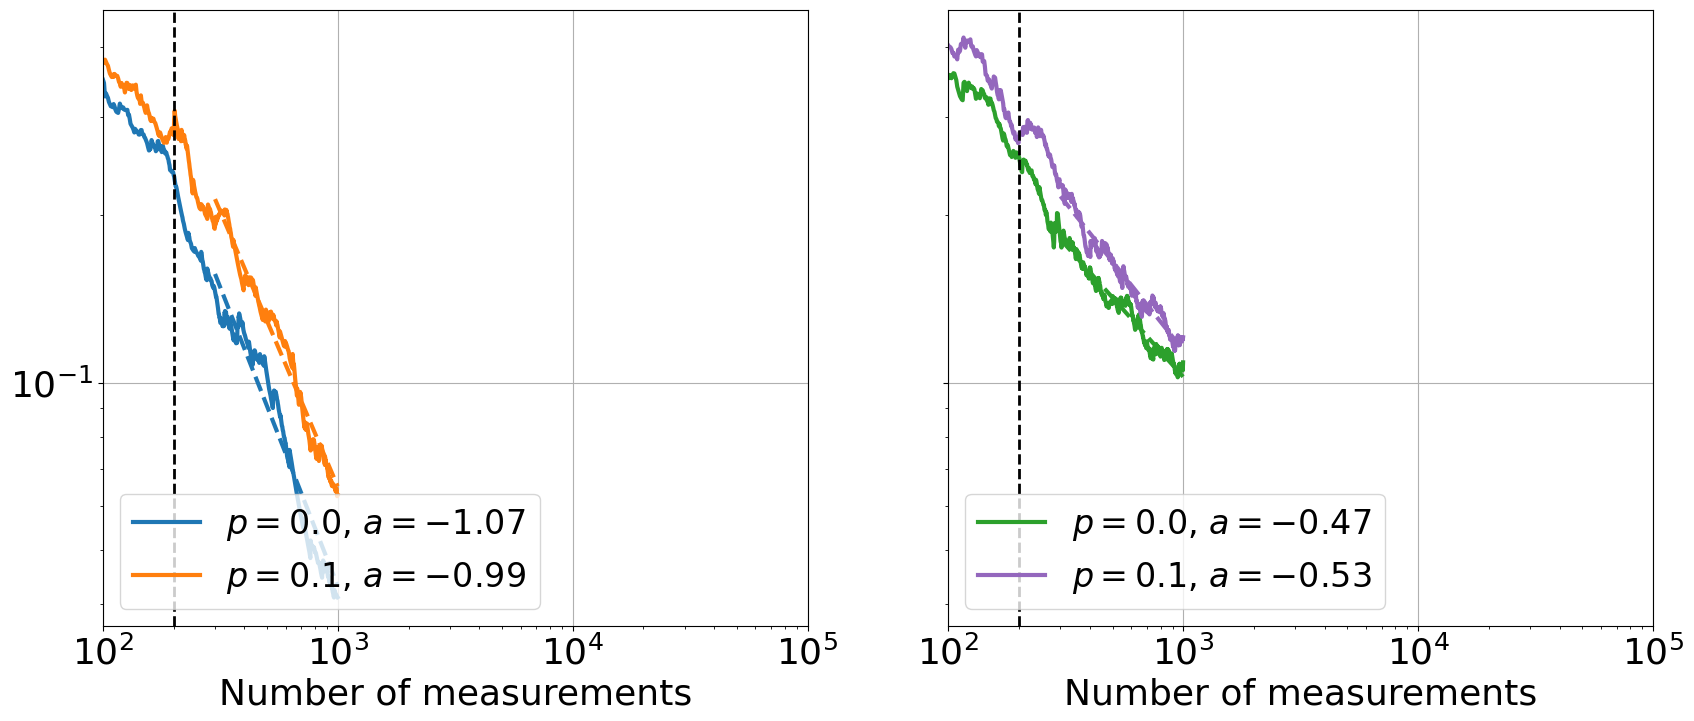

In [67]:
def power_law(x,a,b):
    return a*x**(b)
infidelity_container1 = container_dict['adaptive_infidelity_container']
infidelity_container2 = container_dict['nonadaptive_infidelity_container']

print(np.shape(infidelity_container1))
print(np.shape(infidelity_container2))

cutoff = 100
fitcutoff = 300
x = np.arange(len(infidelity_container1[0][0]))
x_2 = np.arange(len(infidelity_container2[0][0]))

mean_infidelities = [np.mean(container, axis=1) for container in [infidelity_container1, infidelity_container2]]
colors = ['C0', 'C1', 'C2', 'C4', 'red', 'C5', 'C6', 'C7', 'C8'] #  0 and 4 uses same colors as they are the same curve
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
plt.rcParams.update({'font.size': 26})




# Assume mean_infidelities and labels are lists of lists/arrays, where each sublist corresponds to a subplot
# Example: mean_infidelities = [mean_infidelities_set1, mean_infidelities_set2]
#          labels = [labels_set1, labels_set2]
labels = [noise_strengths, noise_strengths]  # Example labels for each subplot
print(labels)
#labels = [[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,10]]
for idx, ax in enumerate(axes):
    for i in range(len(mean_infidelities[idx])):
       
        # if idx == 0 and i == 0:
        #     popt, pcov = curve_fit(power_law, x[fitcutoff:], mean_infidelities[1][i][fitcutoff:], p0=np.array([1, -0.5]))
        #     infiFit = power_law(x[fitcutoff:], popt[0], popt[1])
        #     ax.plot(x[fitcutoff:], infiFit, '--', color=colors[i +1*len(mean_infidelities[0])], linewidth=3)
        #     ax.plot(x[cutoff:], mean_infidelities[1][i][cutoff:], label=rf'$p={np.round(labels[0][i],3)}$, $a={"%.2f" % popt[1]}$' if labels else None, color=colors[i+1*len(mean_infidelities[0])], linewidth=3)
        #print(x[fitcutoff:])
        #print(mean_infidelities[idx][i][fitcutoff:])
        popt, pcov = curve_fit(power_law, x[fitcutoff:], mean_infidelities[idx][i][fitcutoff:], p0=np.array([1, -0.5]))
        infiFit = power_law(x[fitcutoff:], popt[0], popt[1])
        ax.plot(x[fitcutoff:], infiFit, '--', color=colors[i +idx*len(mean_infidelities[0])], linewidth=3)
        #print(labels[idx][i])
        ax.plot(x[cutoff:], mean_infidelities[idx][i][cutoff:], label=rf'$p={np.round(labels[idx][i],3)}$, $a={"%.2f" % popt[1]}$' if labels else None, color=colors[i+idx*len(mean_infidelities[0])], linewidth=3)
    
    ax.axvline(x=200, color='black', linestyle='--', linewidth=2 )
    ax.set_xlabel('Number of measurements')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(cutoff, 100000)
    ax.grid()
    
    ax.legend(loc= "lower left",fontsize=24)

In [ ]:
n_shots_total = 3000
n_qubits = 1
n_shots = n_shots_total//3**n_qubits
n_averages = 1
adaptive_burnin = 500

true_states = np.array([sf.generate_random_pure_state(n_qubits) for _ in range(n_averages)])
povm = POVM.generate_Pauli_POVM(n_qubits)
qst = QST(povm, true_states, n_shots, n_qubits, False,{})
print(f'Total shots: {n_shots_total * n_averages}')
infidelity_container = []
#d_st = 0.000
qst_array = []
noise_strengths = []

qst.perform_adaptive_BME(adaptive_burnin_steps = adaptive_burnin)

#n_steps = 1

# for i in range(n_steps):

#     qst.perform_adaptive_BME(depolarizing_strength = 0,#i*d_st,
#                              adaptive_burnin_steps = adaptive_burnin)
#     infidelity_container.append(qst.get_infidelity())
#     noise_strengths.append(i * d_st)
#     qst_array.append(qst)
    
settings = {
    'n_shots': n_shots,
    'n_qubits': n_qubits,
    'n_averages': n_averages,
    'adaptive_burnin': adaptive_burnin,
    'noise_strengths': noise_strengths,
    'true_states': true_states
}

path = "adaptive_results/test"
now=datetime.now()
now_string = now.strftime("%Y-%m-%d_%H-%M-%S_")
dir_name= now_string+str(uuid.uuid4())
data_path=f'{path}/{dir_name}'
os.mkdir(data_path)

with open(f'{data_path}/infidelity_container.npy', 'wb') as f:
    np.save(f, infidelity_container)
with open(f'{data_path}/settings.npy', 'wb') as f:    
    np.save(f, settings)


Total shots: 3000


KeyboardInterrupt: 

['adaptive_results/two_qubit_infidelities/2025-09-25_10-55-00_788af5f1-d4ea-45ec-94aa-61fd03dd1c5f', 'adaptive_results/two_qubit_infidelities/2025-09-25_10-55-00_a1acd027-e8ed-473a-b673-d1e89974ccdb', 'adaptive_results/two_qubit_infidelities/2025-09-25_10-55-01_c1a5b8ef-88e2-4424-8fe7-404b475aff7a']
(3, 1, 10, 99999)
[7.38964846e-01 7.32692879e-01 7.26187889e-01 ... 5.82080278e-04
 5.82056681e-04 5.82039114e-04]


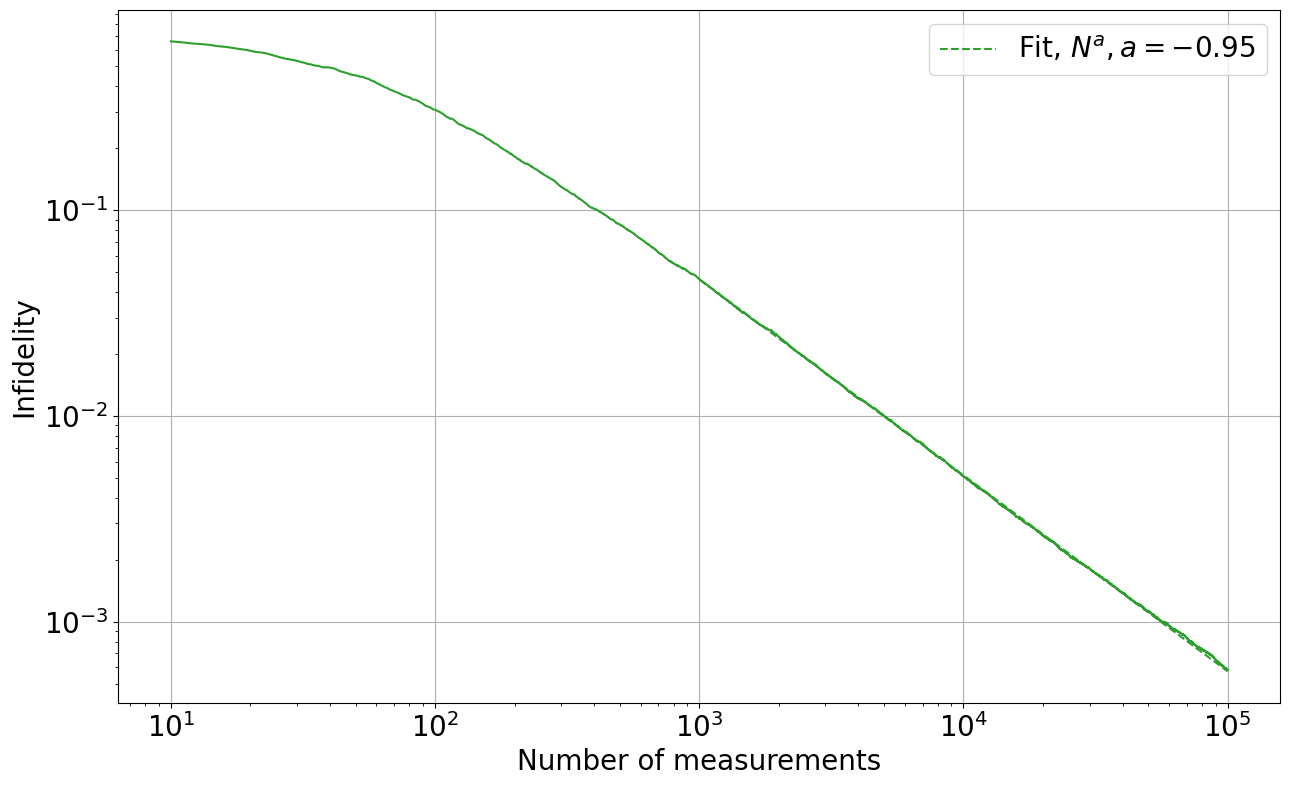

In [17]:
base_path = "adaptive_results/two_qubit_infidelities"
vis.plot_infidelity_from_folders(base_path)

In [ ]:
base_path = "adaptive_results/two_qubit_infidelities"

# Get all directories inside the test folder
#folders = [f for f in glob.glob(os.path.join(base_path, "*")) if os.path.isdir(f)]
vis.plot_infidelity_from_folders(base_path)

# print(folders)
# for i in range(len(folders)):
#     folders[i] = folders[i].replace('\\', '/')  # For Windows compatibility

#     with open(f'{folders[i]}/infidelity_container.npy', 'rb') as f:
#         infidelity_dict = np.load(f, allow_pickle=True).item()
#     with open(f'{folders[i]}/settings.npy', 'rb') as f:    
#         settings = np.load(f, allow_pickle=True).item()

#     print(infidelity_dict.keys())
#     #print(settings.keys())
#     # keys : adaptive_infidelity_container, 
#     vis.plot_from_infidelity_container([infidelity_dict['adaptive_infidelity_container']], adaptive_burnin = settings['adaptive_burnin'])

['adaptive_results/two_qubit_infidelities/2025-09-24_23-55-22_15c4e0ea-361d-46a5-a623-0a4785cbbcf3', 'adaptive_results/two_qubit_infidelities/2025-09-24_23-57-38_6f0f69c2-7845-4c86-b992-de7901eafe42', 'adaptive_results/two_qubit_infidelities/2025-09-24_23-57-40_b6574b5f-4daf-45b7-89c8-f875c64d8d05', 'adaptive_results/two_qubit_infidelities/2025-09-24_23-57-40_ffff19ef-b486-4fc8-8c99-9540e3b17074', 'adaptive_results/two_qubit_infidelities/2025-09-24_23-57-43_89194b5c-9400-44f5-a162-b5c8f12ebb4f', 'adaptive_results/two_qubit_infidelities/2025-09-24_23-57-43_b993893f-31a7-4f2c-a017-9b723a83484c']


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7295cffe7910>>
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [58]:
glob
path = 'adaptive_results/test/2025-09-24_18-49-49_f0e91f6e-751d-4453-98e7-ff0015c30ac4'



with open(f'{path}/infidelity_container.npy', 'rb') as f:
    infidelity_dict2 = np.load(f, allow_pickle=True)#.item()
with open(f'{path}/settings.npy', 'rb') as f:    
    settings = np.load(f, allow_pickle=True).item()

print(infidelity_dict)
print(settings.keys())
# keys : adaptive_infidelity_container, 
vis.plot_from_infidelity_container([infidelity_dict,infidelity_dict2], adaptive_burnin = settings['adaptive_burnin'])

FileNotFoundError: [Errno 2] No such file or directory: 'adaptive_results/test/2025-09-24_18-49-49_f0e91f6e-751d-4453-98e7-ff0015c30ac4/infidelity_container.npy'